In [17]:
import ppi_py as ppi
import numpy as np
import statsmodels as sm
import pandas as pd
import matplotlib.pyplot as plt

In [18]:

def simulate_ols_data(beta, ppi_corr, bias, n, N):
    """
    Simulate data for the OLS example

    Args:
        beta (ndarray): regression coefficients, shape d + 1
        ppi_corr (float): PPI correlation
        bias (float): bias to appl to all coefficients
        n (int): number of labeled samples
        N (int): number of unlabeled samples

    Returns:
        X (ndarray): covariates for labeled data , shape n x (d + 1)
        Y (ndarray): labels, shape n
        Yhat (ndarray): predictions on labeled data, shape n
        X_unlabeled (ndarray): covariates for unlabeled data, shape N x (d + 1)
        Yhat_unlabeled (ndarray): predictions on unlabeled data set shape N
    """

    d = len(beta) - 1

    X = np.random.normal(size=(n, d+1))/(d+1)**0.5
    X[:, 0] = 1

    X_unlabeled = np.random.normal(size=(N, d+1))/(d+1)**0.5
    X_unlabeled[:, 0] = 1

    max_ppi_corr = 1/(2*bias**2+1)**0.5
    max_bias = (0.5*((1/ppi_corr)**2 - 1))**0.5
    assert ppi_corr <= max_ppi_corr, f"ppi_corr must be less than {max_ppi_corr} or bias must be less than {max_bias}"

    rho = ppi_corr * (2*bias**2+1)**0.5

    Z = np.random.normal(size=n)
    Y = X @ beta + rho**0.5 * Z + (1 - rho) ** 0.5 * np.random.normal(size=n)
    Yhat = X @ (beta + bias) + rho**0.5 * Z + (1 - rho) ** 0.5 * np.random.normal(size=n)
    Yhat_unlabeled = X_unlabeled @ (beta + bias) + np.random.normal(size=N)

    return X, Y, Yhat, X_unlabeled, Yhat_unlabeled

beta = np.ones(2)
ppi_corr = 0.5
bias = 1
n = 1000
N = 100000
X, Y, Yhat, X_unlabaled, Yhat_unlabaled = simulate_ols_data(beta, ppi_corr, bias, n, N)
X.shape

(1000, 2)

In [19]:
# true intercept and slope
beta = np.ones(2)

# bias 
bias = 0.3

# PPI correlation
ppi_corr = 0.9

# sample size human subjects
ns = [1000]

# multiples of human subjects sample size
ks = list([0.25, 0.5, 0.75]) + list(np.arange(1, 10.5, 0.5))

# sample size silicon subjects 
Ns = [int(n * k) for n in ns for k in ks]

# number of repetitions for combinations of n and N
reps = 5

# initialize list to collect results
results = []

# initialize a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(seed=20241026)

for r in range(reps):

  if (r+1) % 10 == 0 or r == 0:
    print(f"Repetition {r+1} out of {reps}")

  # simulate data for each repetition
  X, Y, Yhat, X_unlabeled, Yhat_unlabeled = simulate_ols_data(beta=beta, ppi_corr=ppi_corr, bias=bias, n=max(ns), N=max(Ns))

  for n in ns:      

    for N in Ns:

      # sample from labeled data subjects 
      idx_labeled = np.random.choice(X.shape[0], size=n, replace=False)
      X_sampled = X[idx_labeled]
      Y_sampled = Y[idx_labeled]
      Yhat_sampled = Yhat[idx_labeled]

      # sample silicon subjects
      idx_unlabeled = np.random.choice(X_unlabeled.shape[0], size=N, replace=False)
      X_unlabeled_sampled = X_unlabeled[idx_unlabeled]
      Yhat_unlabeled_sampled = Yhat_unlabeled[idx_unlabeled]

      # get coefficient estimate from silicon sampling
      beta_sil = sm.regression.linear_model.OLS(X_unlabeled_sampled, Yhat_unlabeled_sampled).fit().params[0][1]

      # get coefficient estimate from mixed-subjects PPI
      beta_ppi = ppi.ppi_ols_pointestimate(
        X=X_sampled, 
        Y=Y_sampled, 
        Yhat=Yhat_sampled, 
        X_unlabeled=X_unlabeled_sampled, 
        Yhat_unlabeled=Yhat_unlabeled_sampled)[1]

      # append the results to the list as a dictionary
      results.append({
          'beta_ppi': beta_ppi,
          'beta_sil': beta_sil,
          'n': n,
          'N': N,
          'rep': r+1
      })
  
# convert list of dictionaries to a pandas DataFrame
result_df = pd.DataFrame(results)

# (Optional) Display the first few rows of the DataFrame to verify
print(result_df.head(20))

Repetition 1 out of 5
    beta_ppi  beta_sil     n     N  rep
0   0.940767  0.183597  1000   250    1
1   0.931334  0.185279  1000   500    1
2   0.936048  0.188646  1000   750    1
3   0.967362  0.169348  1000  1000    1
4   0.966139  0.184942  1000  1500    1
5   0.965537  0.176039  1000  2000    1
6   0.971178  0.183024  1000  2500    1
7   0.977488  0.175651  1000  3000    1
8   0.986410  0.179478  1000  3500    1
9   0.958262  0.182489  1000  4000    1
10  0.967913  0.183151  1000  4500    1
11  0.965601  0.178393  1000  5000    1
12  0.965641  0.180045  1000  5500    1
13  0.972542  0.181235  1000  6000    1
14  0.978216  0.184559  1000  6500    1
15  0.975387  0.185460  1000  7000    1
16  0.978346  0.182202  1000  7500    1
17  0.982400  0.182179  1000  8000    1
18  0.973120  0.179709  1000  8500    1
19  0.969363  0.180261  1000  9000    1



Averaged Results by n and N:
      n     N  beta_ppi  beta_sil  bias_ppi  bias_sil
0  1000   250  0.949791  0.187496 -0.050209 -0.812504
1  1000   500  0.954886  0.182689 -0.045114 -0.817311
2  1000   750  0.959655  0.184006 -0.040345 -0.815994
3  1000  1000  0.985220  0.189151 -0.014780 -0.810849
4  1000  1500  0.963430  0.180611 -0.036570 -0.819389


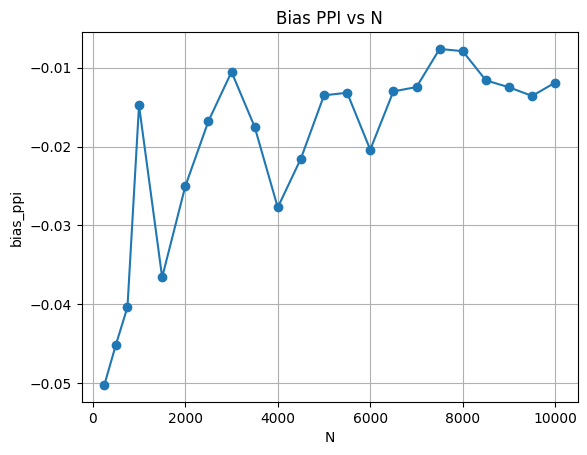

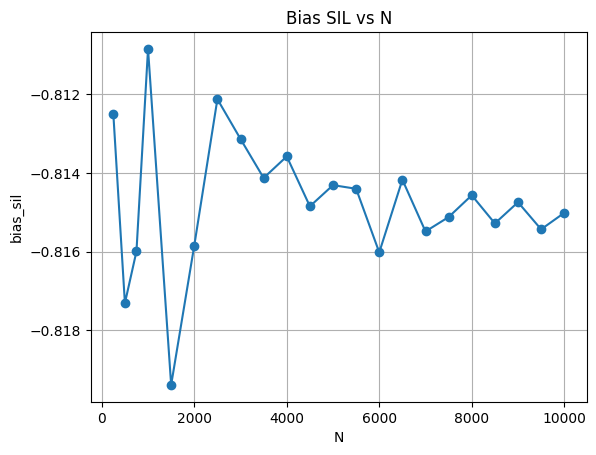

In [20]:
# Group by 'n' and 'N', then calculate the mean of 'beta_ppi' and 'beta_sil'
df = result_df.groupby(['n', 'N'])[['beta_ppi', 'beta_sil']].mean().reset_index()

# Calculate bias columns
df['bias_ppi'] = df['beta_ppi'] - 1
df['bias_sil'] = df['beta_sil'] - 1

# display the first few rows of the averaged DataFrame to verify
print("\nAveraged Results by n and N:")
print(df.head())



# Plot bias_ppi vs N
plt.figure()
plt.plot(df['N'], df['bias_ppi'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('bias_ppi')
plt.title('Bias PPI vs N')
plt.grid(True)
plt.show()

# Plot bias_sil vs N
plt.figure()
plt.plot(df['N'], df['bias_sil'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('bias_sil')
plt.title('Bias SIL vs N')
plt.grid(True)
plt.show()